# Team Assignment 3
## Investing in Peer2Peer Lending

### Authors: Kunal Pathak, Shiva Kammala, Sanjeev Musuvathy, Naomi Burns, and Buse Suer

### Project Outline:

#### 1. import methods and data

#### 2. Prepare the data
- remove unhelpful variables
- impute variables containing relatively few N/A values, or delete those rows
- Remove current investments becuase we don't know whether they will be successful
- one-hot encode categoricals to be compatible with the ML model
- Calculate annual interest gained as the response variable and make assumptions on a successful loan
- remove all columns with values influenced by events that occur after the loan was approved
- Add artificial data-entries to ensure that the model has enough success and failure cases to train on

- Group the data into three groups based on interest rates
    - perform analysis on why this is a good metric in our lending strategy

#### 3. Build the model
- Run a Random Forest to find the most important variables that must be kept for each group
- Build a hyperparameterized model for each group to determine whether or not to invest in a certain loan

#### Using these results, we had sufficient information to develop a sound investment strategy on Peer-to-Peer loans

#### Credits: Lecture Slide 18 for randomized forest and hyperparameterization

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats

# Support functions for much later modeling
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Classification Models
from sklearn.ensemble import RandomForestClassifier

# Scoring Functions
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Pulling the data -- the commented read is on 5% of data for faster run-time
# df_sporadic means the raw uncleaned data

# n = 20
# df_sporadic = pd.read_csv('accepted_2007_to_2018Q4.csv', skiprows=lambda i: i%n)
df_sporadic = pd.read_csv('accepted_2007_to_2018Q4.csv')

In [4]:
df_sporadic['annual_inc_total'] = df_sporadic[['annual_inc', 'annual_inc_joint']].max(axis=1)
df_sporadic['total_dti'] = df_sporadic['dti_joint'].fillna(df_sporadic['dti'])  # higher dti is more risky
df_sporadic['term'] = df_sporadic['term'].str.replace('[^0-9]', '').astype('float')

df_sporadic['il_util'] = df_sporadic['tot_cur_bal'] / df_sporadic['total_il_high_credit_limit']
df_sporadic['mo_sin_old_il_acct'] = df_sporadic['mo_sin_old_il_acct'].fillna(df_sporadic['mo_sin_old_il_acct'].mean())
df_sporadic['mths_since_recent_inq'] = df_sporadic['mths_since_recent_inq'].fillna(df_sporadic['mths_since_recent_inq'].mean())
df_sporadic['mths_since_recent_revol_delinq'] = df_sporadic['mths_since_recent_revol_delinq'].fillna(-1)

df_sporadic['verification_status_total'] = df_sporadic['verification_status_joint'].fillna(df_sporadic['verification_status'])
df_sporadic['earliest_cr_line'] = df_sporadic['earliest_cr_line'].str.slice(4).astype('float')
df_sporadic['issue_d'] = df_sporadic['issue_d'].str.slice(4).astype('float')
df_sporadic['cr_line_since_issue_d'] = df_sporadic['issue_d'] - df_sporadic['earliest_cr_line']

In [5]:
cant_impute = ['cr_line_since_issue_d', 'addr_state', 'loan_amnt', 'int_rate', 'grade', 'emp_length', 'fico_range_high', 'revol_bal', 'total_acc', 'recoveries', 'last_fico_range_high', 'tot_cur_bal', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'annual_inc_total', 'total_dti', 'mo_sin_old_il_acct', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'num_tl_120dpd_2m']
remove_cols = ['loan_status', 'collection_recovery_fee','total_rec_prncp', 'total_rec_late_fee','chargeoff_within_12_mths', 'total_rec_int', 'total_rec_late_fee','sub_grade', 'last_pymnt_d', 'earliest_cr_line', 'issue_d', 'dti', 'dti_joint', 'annual_inc', 'annual_inc_joint', 'id', 'member_id', 'emp_title', 'url', 'desc', 'zip_code', 'fico_range_low', 'last_fico_range_low', 'pymnt_plan', 'title', 'out_prncp', 'out_prncp_inv', 'total_pymnt_inv', 'last_pymnt_amnt', 'last_credit_pull_d', 'next_pymnt_d', 'policy_code', 'hardship_flag', 'hardship_type', 'hardship_reason','hardship_status','deferral_term','hardship_amount','hardship_start_date','hardship_end_date','payment_plan_start_date','hardship_length','hardship_dpd','hardship_loan_status','orig_projected_additional_accrued_interest','hardship_payoff_balance_amount','hardship_last_payment_amount','disbursement_method','debt_settlement_flag','debt_settlement_flag_date','settlement_status','settlement_date','settlement_amount','settlement_percentage','settlement_term', 'revol_bal_joint', 'sec_app_fico_range_low', 'sec_app_fico_range_high', 'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths', 'sec_app_mort_acc','sec_app_open_acc','sec_app_revol_util','sec_app_open_act_il', 'sec_app_num_rev_accts','sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_mths_since_last_major_derog', 'hardship_type','hardship_reason', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record', 'mths_since_recent_bc_dlq', 'verification_status', 'verification_status_joint']
df = df_sporadic[df_sporadic['loan_status'] != 'Current']  # only analyze completed loans
df_sporadic = df_sporadic.drop(remove_cols, axis=1)
df = df_sporadic.dropna(axis=0, subset=cant_impute)

We find the return per year value on each asset. We want to compare to other assets that have no liquidity, so we believe this is a better metric. Likewise, we assume that the year-over-year return should be at least 5% to be a competitive, yet successful investment.

In [6]:
annual_return_rate_cutoff = 5

In [7]:
years = df['term']/12
df['Return_per_year'] = ((df.loc[:,'total_pymnt']/df.loc[:,'funded_amnt'])**(1/years)-1)*100
df['ROI_threshold'] = df['Return_per_year'] > annual_return_rate_cutoff
df['ROI_threshold'] = df['ROI_threshold'].astype('int')
display(df)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,purpose,...,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,annual_inc_total,total_dti,verification_status_total,cr_line_since_issue_d,Return_per_year,ROI_threshold
0,3600.0,3600.0,3600.0,36.0,13.99,123.03,C,10+ years,MORTGAGE,debt_consolidation,...,178050.0,7746.0,2400.0,13734.0,55000.0,5.91,Not Verified,12.0,7.093482,1
1,24700.0,24700.0,24700.0,36.0,11.99,820.28,C,10+ years,MORTGAGE,small_business,...,314017.0,39475.0,79300.0,24667.0,65000.0,16.06,Not Verified,16.0,1.304975,0
2,20000.0,20000.0,20000.0,60.0,10.78,432.66,B,10+ years,MORTGAGE,home_improvement,...,218418.0,18696.0,6200.0,14877.0,71000.0,13.85,Not Verified,15.0,2.570350,0
3,35000.0,35000.0,35000.0,60.0,14.85,829.90,C,10+ years,MORTGAGE,debt_consolidation,...,381215.0,52226.0,62500.0,18000.0,110000.0,17.06,Source Verified,7.0,-2.107548,0
4,10400.0,10400.0,10400.0,60.0,22.45,289.91,F,3 years,MORTGAGE,major_purchase,...,439570.0,95768.0,20300.0,88097.0,104433.0,25.37,Source Verified,17.0,2.454409,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260694,24000.0,24000.0,24000.0,60.0,12.79,543.50,C,7 years,MORTGAGE,home_improvement,...,102517.0,104422.0,0.0,52017.0,95000.0,19.61,Source Verified,17.0,-8.066933,0
2260695,24000.0,24000.0,24000.0,60.0,10.49,515.74,B,10+ years,MORTGAGE,debt_consolidation,...,227883.0,140118.0,27900.0,172283.0,108000.0,34.94,Not Verified,25.0,-8.961439,0
2260696,40000.0,40000.0,40000.0,60.0,10.49,859.56,B,9 years,MORTGAGE,debt_consolidation,...,55970.0,28398.0,12300.0,42670.0,227000.0,12.75,Verified,21.0,-9.041858,0
2260697,24000.0,24000.0,24000.0,60.0,14.49,564.56,C,6 years,RENT,debt_consolidation,...,84664.0,62426.0,20700.0,58764.0,110000.0,18.30,Not Verified,17.0,-22.395311,0


In [8]:
# one-hot ecode categoricals
cat_cols = ['grade', 'home_ownership', 'purpose', 'addr_state', 'initial_list_status', 'application_type', 'verification_status_total']
df_prep = pd.get_dummies(df, columns=cat_cols)
df_prep['emp_length'] = df['emp_length'].str.replace('[^0-9]', '').astype('float')

In [9]:
# convert data entries to be compatible with the model's accepted data types
float64_cols = list(df_prep.select_dtypes(include='float64'))
df_prep[float64_cols] = df_prep[float64_cols].astype('float32')

Investment bands based on the mean and standard deviation of the interest rates calculated below:

0-8% = low-interest
8-18% = med-interest
18+% = high-interest

Our hypothesis is that a higher interest rate means a more risky investment leading to more volatility in the returns. Let's test if this hypothesis is true using a simulation

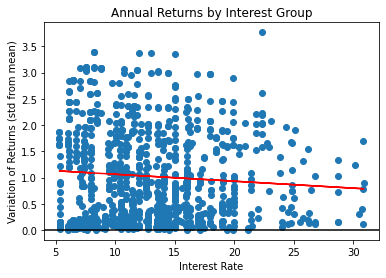

average slope: -0.005759037056265029


In [10]:
slopes = []
r_values = []
for i in range(10):
    graphed_sample = df_prep.sample(n=1000)
    xs = graphed_sample['int_rate']
    std_rpy = graphed_sample['Return_per_year'].std()
    number_of_stds_rpy = abs(graphed_sample['Return_per_year'] / std_rpy)
    z = np.polyfit(xs, number_of_stds_rpy, 1)
    # p = np.poly1d(z)
    slope, intercept, r_value, p_value, std_err = stats.linregress(xs,number_of_stds_rpy)
    slopes.append(slope)
    r_values.append(r_value**2)

plt.scatter(xs, number_of_stds_rpy)
plt.plot(xs, slope*xs+intercept, color='r')
plt.xlabel('Interest Rate')
plt.ylabel('Variation of Returns (std from mean)')
plt.axhline(y=0, color='k')
plt.title('Annual Returns by Interest Group')
plt.show()
# compute average distances and relation between return volatility and interest rate
print('average slope: ' + str(sum(slopes)/len(slopes)))

WOW! We are seeing no **correlation** between interest rate and variablity of returns, or risk. Therefore, we will try to pursue loans that have a higher interest rate. This is an oversimplifaction, however, it is backed by these data. Likewise, the model at the end of this notebook supports our assumption.

In [11]:
print('Mean of interest rate = ' + str(df_prep['int_rate'].mean()))
print('Standard deviation of interest rate = ' + str(df_prep['int_rate'].std()))

Mean of interest rate = 12.881595611572266
Standard deviation of interest rate = 5.090041637420654


In [12]:
synthetic_df = df_prep[df_prep['ROI_threshold'] == 1]
synthetic_df = synthetic_df.append(df_prep[df_prep['ROI_threshold'] == 1])
synthetic_df = synthetic_df.append(df_prep[df_prep['ROI_threshold'] == 0].sample(n=len(synthetic_df)))
synthetic_df.reset_index(drop=True, inplace=True)
groups = synthetic_df.groupby(pd.cut(synthetic_df['int_rate'], [0, 8, 18, 100], labels=['low_int', 'med_int', 'high_int']))

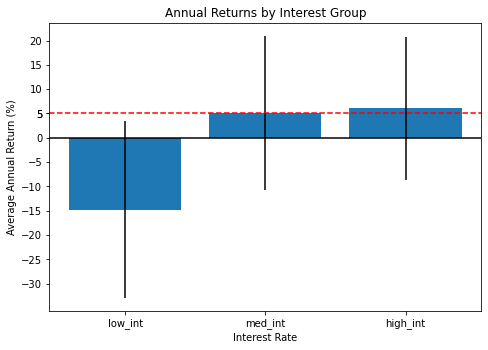

In [13]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
group_labels = []
avg_return = []
error = []
for group in groups:
    group_labels.append(group[0])
    avg_return.append(group[1]['Return_per_year'].median())
    error.append(group[1]['Return_per_year'].std())
ax.bar(group_labels,avg_return, yerr=error)
plt.xlabel('Interest Rate')
plt.ylabel('Average Annual Return (%)')
yticks = np.arange(-30, 25, 5)
yticks = np.append(yticks, annual_return_rate_cutoff)
plt.yticks(yticks)
plt.axhline(y=annual_return_rate_cutoff, color='r', linestyle='--')
plt.axhline(y=0, color='k')
plt.title('Annual Returns by Interest Group')
plt.show()

In [14]:
def show_results(y_test, y_pred):
  # show_results function pulled from lecture 18
  print('accuracy score: ' + str(accuracy_score(y_test, y_pred)))
  con_matrix = confusion_matrix(y_test, y_pred)
  confusion_matrix_df = pd.DataFrame(con_matrix, ('Reject', 'Accept'), ('Reject', 'Accept'))
  heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d", cmap="Blues")
  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 14)
  plt.ylabel('Actual', fontsize = 14)
  plt.xlabel('Predicted', fontsize = 14)
  # 2c. Print the classification report
  print(classification_report(y_test, y_pred))
  plt.show()

In [15]:
# adaptive boosting trains one tree and finds what it got wrong and then focuses on that
# random forest is a group of independently trained trees
def build_forest(df, show_res=True, show_shape=True, estimators=25, max_depth=9):
    y = df.ROI_threshold
    X = df.drop(columns=['ROI_threshold'])
    column_names = X.columns
    X = pd.DataFrame(np.nan_to_num(X.astype(np.float32)))
    X.columns = column_names.values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
    if show_shape:
        print("Train: Response Variable: ",y_train.shape)
        print("Train: Feature Variables: ",X_train.shape)
        print("Test: Response Variable: ",y_test.shape)
        print("Test: Feature Variables: ",X_test.shape)

    forest = RandomForestClassifier(max_features=None, n_estimators=estimators, max_depth=max_depth, random_state=21)

    # 2. Train the model using the training sets
    forest.fit(X_train, y_train)  

    # 3. Predict the response for test dataset
    y_pred = forest.predict(X_test)

    # 4. Call function to evaluate and show model performance
    if show_res:
        show_results(y_test, y_pred)
    return forest, X_train, X_test, y_train, y_test

low_int
Train: Response Variable:  (22884,)
Train: Feature Variables:  (22884, 39)
Test: Response Variable:  (9808,)
Test: Feature Variables:  (9808, 39)
1.0
{'max_depth': 6, 'n_estimators': 25}
RandomForestClassifier(max_depth=6, n_estimators=25, random_state=21)
accuracy score: 0.9991843393148451
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9787
           1       1.00      0.62      0.76        21

    accuracy                           1.00      9808
   macro avg       1.00      0.81      0.88      9808
weighted avg       1.00      1.00      1.00      9808



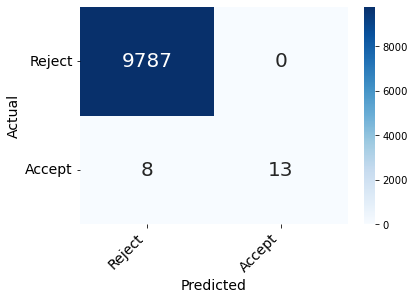



med_int
Train: Response Variable:  (152612,)
Train: Feature Variables:  (152612, 39)
Test: Response Variable:  (65406,)
Test: Feature Variables:  (65406, 39)
0.759622426812949
{'max_depth': 12, 'n_estimators': 50}
RandomForestClassifier(max_depth=12, n_estimators=50, random_state=21)
accuracy score: 0.810705439867902
              precision    recall  f1-score   support

           0       0.90      0.68      0.77     30994
           1       0.76      0.93      0.84     34412

    accuracy                           0.81     65406
   macro avg       0.83      0.80      0.81     65406
weighted avg       0.83      0.81      0.81     65406



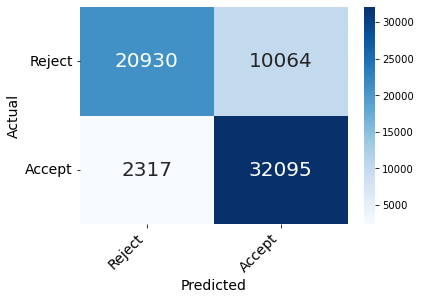



high_int
Train: Response Variable:  (45893,)
Train: Feature Variables:  (45893, 39)
Test: Response Variable:  (19669,)
Test: Feature Variables:  (19669, 39)
0.7840347547707458
{'max_depth': 12, 'n_estimators': 25}
RandomForestClassifier(max_depth=12, n_estimators=25, random_state=21)
accuracy score: 0.7956683105394275
              precision    recall  f1-score   support

           0       0.82      0.50      0.63      6661
           1       0.79      0.95      0.86     13008

    accuracy                           0.80     19669
   macro avg       0.81      0.72      0.74     19669
weighted avg       0.80      0.80      0.78     19669



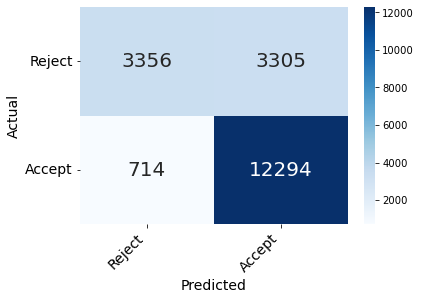

In [17]:
# 1. Extract features and their importances
for group in groups:
    print(group[0])
    data = group[1].drop(columns=['Return_per_year', 'total_pymnt'])
    forest, X_train, X_test, y_train, y_test = build_forest(data, show_res=False, show_shape=False)
    feat_importances = pd.Series(forest.feature_importances_, index=X_train.columns)

    # 2. Sort importances_rf
    sorted_importances_rf = feat_importances.sort_values()
    val = sorted_importances_rf[sorted_importances_rf != 0]
    # print('Best 3 indicators for ' + str(group[1]) + ' = ' + val[::-1][:3])

    # rerun the forest with the top 25% of indicators, ~ top 39 variables
    top_25_perc_feats = val[::-1][:39]
    data_new = data[top_25_perc_feats.index]
    data_new['ROI_threshold'] = data['ROI_threshold']
    forest, X_train, X_test, y_train, y_test = build_forest(data_new, show_res=False)

    # hyperparameterize this now for a better model
    # 1. Define grid (i.e., hyperparameter combinations to test for)
    param_grid = {'n_estimators': [10, 25, 50], 'max_depth' : [6, 9, 12]}

    # 2. Instantiate the model (do not include parameters from the parameter grid in the classifier that you use; here, RandomForestClassifier())
    forest_Grid = GridSearchCV(RandomForestClassifier(random_state=21), param_grid, cv=5, refit=True, verbose=0, scoring = 'precision')

    # 3. Fit the model (i.e., train it on training data)
    forest_Grid.fit(X_train, y_train)

    # 4. Output optimal Hyperparameter combination
    best_score = forest_Grid.best_score_
    best_params = forest_Grid.best_params_
    best_estimator = forest_Grid.best_estimator_
    print(best_score)
    print(best_params)
    print(best_estimator)

    # 5. Model is already trained with the optimal parameters identified and set: Use it to make prediction
    y_pred = forest_Grid.predict(X_test)

    # 6. Call function to evaluate model performance and show results
    show_results(y_test, y_pred)

    
    print()
    print()

INVESTMENT STRATEGY DECOMPOSITION

PER GROUP
Find average annual return percent
Find total lent
Find number of total loans

In [18]:
low_int = groups.get_group('low_int')
med_int = groups.get_group('med_int')
high_int = groups.get_group('high_int')

# Find sharpe ratio using average ROI_per_year, total lent, number of total loans in each group

low_int_roi = low_int['Return_per_year'].median()
med_int_roi = med_int['Return_per_year'].median()
high_int_roi = high_int['Return_per_year'].median()

low_int_lent = low_int['funded_amnt'].sum()
med_int_lent = med_int['funded_amnt'].sum()
high_int_lent = high_int['funded_amnt'].sum()

low_int_count = len(low_int)
med_int_count = len(med_int)
high_int_count = len(high_int)

# print(low_int_roi)
print(low_int_roi, med_int_roi, high_int_roi)
print(low_int_lent, med_int_lent, high_int_lent)
print(low_int_count, med_int_count, high_int_count)

-14.772529602050781 5.0742340087890625 6.0194854736328125
494151870.0 3107362000.0 1046860160.0
32692 218018 65562
